In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
sys.path.append('../spock/')
from modelfitting import ROC_curve, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

# Paths to where we store the training data and the models

In [41]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
modelpath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/models/'
models = {'N-body':'shadowtimesxgb_random', 'SPOCK':'spock_random', 'Hill':'HillSpheresxgb_random', 'MEGNO':'megnoxgb_random', 'AMD':'AMD_random'}

# Resonant

N-body 0.9893085051797815
SPOCK 0.9338657754342667
MEGNO 0.8537492446019923
AMD 0.7312126022558687
Hill 0.7032226514248359


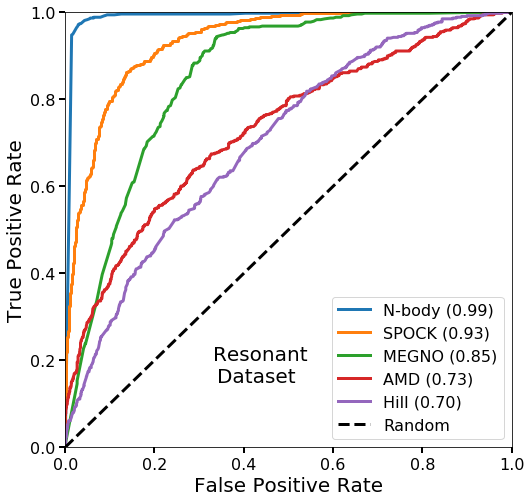

In [20]:
models = {'N-body':'nbody', 'SPOCK':'spock', 'MEGNO':'megno', 'AMD':'AMD', 'Hill':'hill'}
testing_dataset = 'resonant'

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')


for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features)
    print(name, roc_auc)
    ax.plot(fpr, tpr, label='{0} ({1:.2f})'.format(name, roc_auc))

ax.plot(np.linspace(0,1), np.linspace(0,1), 'k--', label='Random')
ax.text(0.33, 0.2, "Resonant", fontsize=20)
ax.text(0.34, 0.15, "Dataset", fontsize=20)
ax.legend()
fig.savefig('resperformance.pdf', bbox_inches='tight')

In [14]:
FPRthresh = 0.1

for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features,  filtertimes=True)
    threshindex = np.where(fpr > FPRthresh)[0][0]
    print(name, "thresh = {0:.3f}".format(ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))

N-body thresh = 0.250 TPR = 0.994 FPR = 0.103
SPOCK thresh = 0.796 TPR = 0.797 FPR = 0.104
MEGNO thresh = 0.983 TPR = 0.464 FPR = 0.103
AMD thresh = 0.928 TPR = 0.375 FPR = 0.100
Hill thresh = 0.909 TPR = 0.281 FPR = 0.101


In [13]:
TPRthresh = 0.9

for name, filename in models.items():
    model, features, featureargs, featurefolder = dill.load(open('../models/'+filename+'.pkl', "rb"))
    testingdatafolder = '../training_data/resonant/'+featurefolder
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features,  filtertimes=True)
    threshindex = np.where(tpr > TPRthresh)[0][0]
    print(name, "thresh = {0:.3f}".format(ROCthresholds[threshindex]),  "TPR = {0:.3f}".format(tpr[threshindex]), "FPR = {0:.3f}".format(fpr[threshindex]))

N-body thresh = 0.995 TPR = 0.948 FPR = 0.014
SPOCK thresh = 0.384 TPR = 0.900 FPR = 0.197
MEGNO thresh = 0.936 TPR = 0.900 FPR = 0.307
AMD thresh = 0.687 TPR = 0.900 FPR = 0.722
Hill thresh = 0.692 TPR = 0.902 FPR = 0.670
